# Reading in data

In [104]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Define constants
DATA_DIR = r'C:\Mini_Project\output\20251119\data'
STRIKES = [0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2]
MATURITIES = [30, 60, 90, 120, 150, 180, 360]
START_DATE = datetime(2015, 11, 2)
END_DATE = datetime(2025, 10, 31)

# Generate the list of dates in the range (closed interval)
all_dates = pd.date_range(START_DATE, END_DATE, freq='B')  # Use business days if needed, else use 'D'


In [ ]:
import re

data_dir = r'C:\Mini_Project\output\20251119\data'
real_data_dir = os.path.join(data_dir, "real_data")

prices_file = os.path.join(real_data_dir, "option_prices.csv")

prices_df = pd.read_csv(prices_file, parse_dates=True)
prices_df.set_index('Unnamed: 0', inplace=True)

pattern = r"strike_([0-9\.]+)_maturity_([0-9]+)"

records = []
for col in prices_df.columns:
    match = re.match(pattern, col)
    if match:
        strike = float(match.group(1))
        maturity_days = int(match.group(2))
        maturity_years = maturity_days / 365.0

        for idx, row in prices_df.loc[:, [col]].iterrows():
            date = idx
            option_price = row.values[0]

            records.append({
                'date': date,
                'relative_strike': strike,
                'maturity_days': maturity_days,
                'maturity_years': maturity_years,
                'option_price': option_price
            })

prices_df_long = pd.DataFrame(records)

import glob

# The yearly data folders are located under DATA_DIR, one per year
yearly_folders = sorted([f for f in glob.glob(os.path.join(DATA_DIR, '*')) if os.path.isdir(f) and re.match(r'.*(20\d{2})$', f)])
all_year_prices = []

for folder in yearly_folders:
    # Extract year from folder name assuming it ends with the year YYYY
    year_match = re.search(r'(20\d{2})$', folder)
    if not year_match:
        continue
    year = year_match.group(1)
    price_file = os.path.join(folder, f"^NDX_options_data_{year}.csv")
    yearly_df = pd.read_csv(price_file)
    if 'date' in yearly_df.columns:
        yearly_df['date'] = pd.to_datetime(yearly_df['date'])
    all_year_prices.append(yearly_df)

if all_year_prices:
    # Combine all yearly dataframes into one
    all_prices_df = pd.concat(all_year_prices, ignore_index=True)
else:
    all_prices_df = pd.DataFrame()
# Ensure date types are compatible for merging
prices_df_long['date'] = pd.to_datetime(prices_df_long['date'])

# Merge in current_price from the yearly data files (require 'date', 'strike', 'maturity_days', 'current_price')
prices_df_long = prices_df_long.merge(
    all_prices_df[['date', 'relative_strike','strike', 'maturity_days', 'current_price']],
    on=['date', 'relative_strike', 'maturity_days'],
    how='left'
)


In [105]:
def load_RFR_data(data_dir, start_date, end_date):

    all_rfr_data = pd.read_csv(os.path.join(data_dir, "EFFR.csv"))
    all_rfr_data.ffill(inplace=True)
    all_rfr_data['EFFR'] = (all_rfr_data['EFFR'] / 100).astype(float) # percentage to decimal
    all_rfr_data['observation_date'] = pd.to_datetime(all_rfr_data['observation_date'])
    all_rfr_data.set_index('observation_date', inplace=True)
    rfr_data = all_rfr_data.loc[(all_rfr_data.index >= pd.to_datetime(START_DATE)) & (all_rfr_data.index <= pd.to_datetime(END_DATE))]
    return rfr_data


rfr_path = os.path.join(DATA_DIR, '../../../raw_data')
rfr_data = load_RFR_data(rfr_path, START_DATE, END_DATE)


In [126]:
options_data = prices_df_long.merge(rfr_data, left_on='date', right_index=True, how='left')
options_data.head()

,date,relative_strike,maturity_days,maturity_years,option_price,strike,current_price,EFFR
0,2015-11-02,0.8,30,0.082192,941.946280,3775.0,4703.919922,0.0012
1,2015-11-03,0.8,30,0.082192,945.216501,3775.0,4719.049805,0.0012
2,2015-11-04,0.8,30,0.082192,945.734158,3775.0,4717.549805,0.0012
3,2015-11-05,0.8,30,0.082192,942.932446,3750.0,4702.899902,0.0012
4,2015-11-06,0.8,30,0.082192,942.011448,3775.0,4707.229980,0.0012


## Pricing functions
Take from https://www.codearmo.com/python-tutorial/merton-jump-diffusion-model-python
based on 

$$V_{MJD}(S,K,T,r,\sigma, m,v, \lambda) = \sum_{k=0}^{\infty} \dfrac{\exp(-m \lambda T) (m \lambda T)^k}{k!} V_{BS} (S,K,T,r_n, \sigma_k)$$

where conditioned on $k$ jumps:

$$\sigma_k = \sqrt{\sigma^2 + k \frac{v^2}{T} r_k} = r - \lambda(m-1) + \dfrac{k \log (m)}{T}$$

In [127]:
import numpy as np
from scipy.stats import norm
from scipy.special import factorial
N = norm.cdf

def BS_CALL(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * N(d1) - K * np.exp(-r*T)* N(d2)

def BS_PUT(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma* np.sqrt(T)
    return K*np.exp(-r*T)*N(-d2) - S*N(-d1)    

def merton_jump_call(S, K, T, r, sigma, m , v, lam):
    p = 0
    for k in range(40):
        r_k = r - lam*(m-1) + (k*np.log(m) ) / T
        sigma_k = np.sqrt( sigma**2 + (k* v** 2) / T)
        k_fact = factorial(k)
        p += (np.exp(-m*lam*T) * (m*lam*T)**k / (k_fact))  * BS_CALL(S, K, T, r_k, sigma_k)
    
    return p

def merton_jump_put(S, K, T, r, sigma, m , v, lam):
    p = 0 # price of option
    for k in range(40):
        r_k = r - lam*(m-1) + (k*np.log(m) ) / T
        sigma_k = np.sqrt( sigma**2 + (k* v** 2) / T)
        k_fact = factorial(k)
        p += (np.exp(-m*lam*T) * (m*lam*T)**k / (k_fact)) \
                    * BS_PUT(S, K, T, r_k, sigma_k)
    return p 

In [ ]:
from scipy.optimize import minimize
import json

def optimal_params(x, mkt_prices, strikes, option_types):
    # Vectorize the pricing function over strikes, using appropriate function based on option type
    candidate_prices = []
    for K, opt_type in zip(strikes, option_types):
        if opt_type.lower() == 'call':
            price = merton_jump_call(S, K, T, r, sigma=x[0], m=x[1], v=x[2], lam=x[3])
        else:  # put
            price = merton_jump_put(S, K, T, r, sigma=x[0], m=x[1], v=x[2], lam=x[3])
        candidate_prices.append(price)
    candidate_prices = np.array(candidate_prices)
    return np.linalg.norm(mkt_prices - candidate_prices, 2)

# Loop over unique Mondays in 'date' column of options_data
jump_params = {}

# Ensure 'date' column is datetime
options_data['date'] = pd.to_datetime(options_data['date'])

# Get unique Mondays present in data
mondays = options_data[options_data['date'].dt.weekday == 0]['date'].dt.strftime('%Y-%m-%d').unique()

for date in mondays:
    print(f"    Processing date: {date}")
    single_option_ts = options_data[options_data['date'] == pd.to_datetime(date)]
    single_option_ts = single_option_ts.reset_index(drop=True)

    if single_option_ts.empty:
        continue  # skip if there is no data for this date

    T = single_option_ts.iloc[0].maturity_years
    S = single_option_ts.iloc[0].current_price
    r = single_option_ts.iloc[0].EFFR

    # Construct option_type based on strike vs spot price
    # If K > S, then 'call', otherwise 'put'
    single_option_ts['option_type'] = single_option_ts['strike'].apply(
        lambda K: 'call' if K > S else 'put'
    )

    x0 = [0.15, 1, 0.1, 1]  # initial guess for algorithm

    # Bounds:
    # vol: 0.01 < sigma < inf 
    # mean jump: 0.01 < m < 5
    # std jump: 0.01 < v < 2
    # intensity: 0 < lam < 40
    # bounds = ((0.01, np.inf), (0.01, 5), (1e-5, np.inf), (0, 40)) # produced VERY large jumps
    bounds = ((0.01, 2), (0.01, 5), (1e-5, 2), (0, 40))
    strikes = single_option_ts['strike'].values
    prices = single_option_ts['option_price'].values
    option_types = single_option_ts['option_type'].values

    res = minimize(optimal_params, method='SLSQP', x0=x0, args=(prices, strikes, option_types),
                   bounds=bounds, tol=1e-2,
                   options={"maxiter": 100, "disp": True})
    sigt = res.x[0]
    mt = res.x[1]
    vt = res.x[2]
    lamt = res.x[3]

    jump_params[date] = {
        'spot_price': S,
        'risk_free_rate': r,
        'time_to_maturity': T,
        'volatility': sigt,
        'jump_mean': mt,
        'jump_std': vt,
        'jump_intensity': lamt
    }

print(f"    Final objective value: {res.fun}, Number of iterations: {res.nit}")
print(f"    Calibrated Volatility = {sigt}, Jump Mean = {mt}, Jump Std = {vt}, Jump Intensity = {lamt}")
with open("jump_process_params.log", "w") as f:
    json.dump(jump_params[date], f, indent=4, default=str)
print("    Jump process parameters written to jump_process_params.log.")


    Processing date: 2015-11-02
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2090.0960645657387
            Iterations: 14
            Function evaluations: 88
            Gradient evaluations: 14
    Processing date: 2015-11-09
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2037.8883145105453
            Iterations: 13
            Function evaluations: 82
            Gradient evaluations: 13
    Processing date: 2015-11-16
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2001.3565202458594
            Iterations: 9
            Function evaluations: 64
            Gradient evaluations: 9
    Processing date: 2015-11-23
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2169.341733978253
            Iterations: 15
            Function evaluations: 93
            Gradient evaluations: 14
    Processing date: 2015-11-30
Opt

In [145]:
import json
with open("jump_process_params.log", "w") as f:
    json.dump(jump_params, f, indent=4, default=str)
print("    Jump process parameters written to jump_process_params.log.")
# Write jump_params as a log to jump_process_params.log



    Jump process parameters written to jump_process_params.log.


Text(0.5, 1.0, 'Jump Diffusion Process')

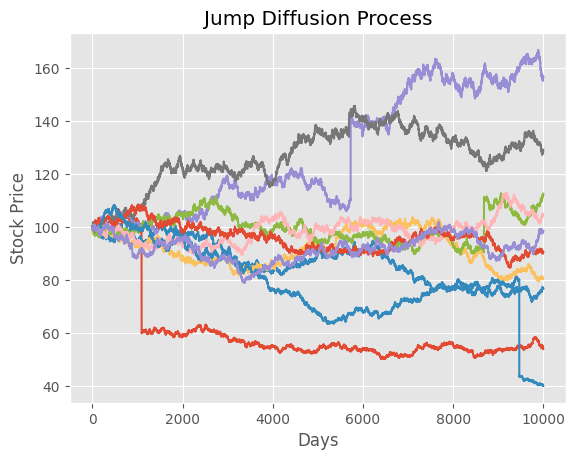

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np

def merton_jump_paths(S_array, T, r, sigma,  lam, m, v, steps, Npaths):
    # Validate inputs
    if steps <= 0:
        raise ValueError(f"steps must be positive, got {steps}")
    if T <= 0:
        raise ValueError(f"T must be positive, got {T}")
    
    # Convert S_array to numpy array and validate shape
    S_array = np.asarray(S_array)
    if S_array.ndim != 1:
        raise ValueError(f"S_array must be 1D, got shape {S_array.shape}")
    if len(S_array) != Npaths:
        raise ValueError(f"S_array length ({len(S_array)}) must match Npaths ({Npaths})")
    
    size=(steps,Npaths)
    dt = T/steps 
    
    # Cap lam*dt to prevent Poisson overflow (NumPy Poisson has practical limit around 1e6)
    # Use a reasonable cap of 1000
    lam_dt = lam * dt
    if lam_dt > 1000:
        print(f"Warning: lam*dt={lam_dt:.2f} is too large, capping to 1000")
        lam_dt = 1000
    
    poi_rv = np.multiply(np.random.poisson(lam_dt, size=size),
                         np.random.normal(m, v, size=size)).cumsum(axis=0)
    geo = np.cumsum(((r -  sigma**2/2 -lam*(m  + v**2*0.5))*dt +\
                      sigma*np.sqrt(dt) * \
                      np.random.normal(size=size)), axis=0)
    
    # Broadcast S_array to match the shape of exp(geo+poi_rv) which is (steps, Npaths)
    # S_array has shape (Npaths,), so we need to add a new axis to broadcast correctly
    return np.exp(geo+poi_rv) * S_array[np.newaxis, :]




In [174]:
# Simulate Merton jump paths for all dates in options_data
# Use the most recent parameters from jump_params for each date

# Get all unique dates from options_data, sorted
all_dates_in_data = sorted(options_data['date'].unique())
all_dates_in_data = pd.to_datetime(all_dates_in_data)

# Convert jump_params keys to datetime for comparison
jump_params_dates = sorted([pd.to_datetime(date) for date in jump_params.keys()])

# Parameters for simulation
steps = 252  # Number of time steps (e.g., daily for 1 year)
Npaths = 100  # Number of paths to simulate
dt = 1/252  # Time step (1 day, assuming 252 trading days per year)

# Store simulated paths
simulated_paths = {}

print(f"Simulating Merton jump paths for {len(all_dates_in_data)} dates...")
print(f"Using parameters from {len(jump_params_dates)} calibration dates")

start_date = all_dates_in_data[0]

for current_date_str, params in jump_params.items():
    current_date = pd.to_datetime(current_date_str)  # Convert string to Timestamp
    print(current_date)
    
    if current_date == start_date:
        S_array = np.full(Npaths, params['spot_price'])
    else:
        S_array = simulated_paths[prev_date]['paths'][-1, :]

    future_params_dates = [d for d in jump_params_dates if d > current_date]
    
    next_param_date = min(future_params_dates) if future_params_dates else None
    if next_param_date is not None:
        n_days = (next_param_date - current_date).days
    else:
        # Last interval: simulate until the last date in options_data
        n_days = (max(all_dates_in_data) - current_date).days
    
    
    r = params['risk_free_rate']
    sigma = params['volatility']
    lam = params['jump_intensity']
    m = params['jump_mean']
    v = params['jump_std']
    
    # Calculate T based on the actual interval length (in years)
    # Assuming 252 trading days per year
    T = n_days / 252.0
    n_steps = max(1, n_days)  # Ensure at least 1 step
    
    # Simulate paths
    try:
        paths = merton_jump_paths(S_array, T, r, sigma, lam, m, v, n_steps, Npaths)
    except (ValueError, Exception) as e:
        print(f"  Error simulating {current_date_str}: {e}")
        print(f"    Parameters: T={T:.4f}, n_steps={n_steps}, lam={lam:.4f}, lam*dt={lam*T/n_steps:.4f}")
        continue
    
    # Store the simulated paths
    simulated_paths[current_date_str] = {
        'paths': paths,
        'parameters_date': current_date_str,
        'parameters': params
    }
    prev_date = current_date_str

print(f"Completed simulation for {len(simulated_paths)} dates")


Simulating Merton jump paths for 252 dates...
Using parameters from 48 calibration dates
2015-11-02 00:00:00
2015-11-09 00:00:00
2015-11-16 00:00:00
2015-11-23 00:00:00
2015-11-30 00:00:00
2015-12-07 00:00:00
2015-12-14 00:00:00
2015-12-21 00:00:00
2015-12-28 00:00:00
2016-01-04 00:00:00
2016-01-11 00:00:00
2016-01-25 00:00:00
2016-02-01 00:00:00
2016-02-08 00:00:00
2016-02-22 00:00:00
2016-02-29 00:00:00
2016-03-07 00:00:00
2016-03-14 00:00:00
2016-03-21 00:00:00
2016-03-28 00:00:00
2016-04-04 00:00:00
2016-04-11 00:00:00
2016-04-18 00:00:00
2016-04-25 00:00:00
2016-05-02 00:00:00
2016-05-09 00:00:00
2016-05-16 00:00:00
2016-05-23 00:00:00
2016-06-06 00:00:00
2016-06-13 00:00:00
2016-06-20 00:00:00
2016-06-27 00:00:00
2016-07-11 00:00:00
2016-07-18 00:00:00
2016-07-25 00:00:00
2016-08-01 00:00:00
2016-08-08 00:00:00
2016-08-15 00:00:00
2016-08-22 00:00:00
2016-08-29 00:00:00
2016-09-12 00:00:00
2016-09-19 00:00:00
2016-09-26 00:00:00
2016-10-03 00:00:00
2016-10-10 00:00:00
2016-10-17 

In [182]:
for k, v in simulated_paths.items():
    paths = v['paths']
    params = v['parameters']
    print(f"{k}:")
    print(paths[0,:])
    print(params)

2015-11-02:
[4652.59005113 4707.63419074 4679.54407765 4727.6195267  4735.2515647
 4635.60827802 4674.86667546 4699.63095399 4647.6538492  4685.14880009
 4710.44356831 4712.37945318 4655.87960814 4700.93000901 4706.71167795
 4712.6773447  4708.30422779 4657.15949208 4702.03471391 4670.67045926
 4699.04099969 4669.94711032 4668.00773131 4707.25963394 4689.55281358
 4630.29786924 4668.80042328 4719.50155932 4656.69643572 4635.20359734
 4695.76494816 4650.73747957 4703.68797744 4697.3437147  4722.22097693
 4682.76668434 4690.62300348 4738.36888225 4685.12797299 4716.97480481
 4676.98664427 4688.84482885 4769.83211063 4660.64632245 4650.86807824
 4657.91256233 4719.67789221 4672.5158237  4665.05440068 4712.83354445
 4651.34090032 4672.04838989 4726.57703571 4716.04860038 4638.77505987
 4666.18809886 4736.2850591  4687.70044124 4674.40101396 4632.34931733
 4666.0701629  4610.45188874 4659.23612921 4705.90043576 4721.35442607
 4678.11924427 4693.52239119 4677.34769419 4692.28794988 4705.3316

In [ ]:
j = merton_jump_paths(S, T, r, sigma, lam, m, v, steps, Npaths)

plt.plot(j)
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.title('Jump Diffusion Process')

In [183]:
# Analyze which parameters are causing paths to jump very close to 0

# Threshold for "very close to 0" - adjust as needed
ZERO_THRESHOLD = 1.0  # Paths below this value are considered problematic

print("Analyzing paths to identify parameters causing jumps near 0...")
print("=" * 80)

problematic_intervals = []
all_path_stats = []

for date_str, data in simulated_paths.items():
    paths = data['paths']  # Shape: (n_steps, Npaths)
    params = data['parameters']
    
    # Check for paths that go very close to 0
    min_values = np.min(paths, axis=0)  # Minimum value for each path in this interval
    paths_near_zero = np.sum(min_values < ZERO_THRESHOLD)
    
    # Calculate statistics
    mean_min = np.mean(min_values)
    median_min = np.median(min_values)
    min_of_all = np.min(min_values)
    max_of_all = np.max(paths)
    
    # Store statistics
    stats = {
        'date': date_str,
        'paths_near_zero': paths_near_zero,
        'total_paths': paths.shape[1],
        'min_value': min_of_all,
        'mean_min': mean_min,
        'median_min': median_min,
        'max_value': max_of_all,
        'volatility': params.get('volatility', np.nan),
        'jump_intensity': params.get('jump_intensity', np.nan),
        'jump_mean': params.get('jump_mean', np.nan),
        'jump_std': params.get('jump_std', np.nan),
        'risk_free_rate': params.get('risk_free_rate', np.nan),
        'spot_price': params.get('spot_price', np.nan),
    }
    all_path_stats.append(stats)
    
    # Flag problematic intervals
    if paths_near_zero > 0 or min_of_all < ZERO_THRESHOLD:
        problematic_intervals.append(stats)
        print(f"\n⚠️  PROBLEMATIC: {date_str}")
        print(f"   Paths near zero (< {ZERO_THRESHOLD}): {paths_near_zero}/{paths.shape[1]}")
        print(f"   Minimum value: {min_of_all:.4f}")
        print(f"   Mean minimum: {mean_min:.4f}")
        print(f"   Parameters:")
        print(f"     Volatility (σ): {params.get('volatility', 'N/A'):.6f}")
        print(f"     Jump Intensity (λ): {params.get('jump_intensity', 'N/A'):.6f}")
        print(f"     Jump Mean (m): {params.get('jump_mean', 'N/A'):.6f}")
        print(f"     Jump Std (v): {params.get('jump_std', 'N/A'):.6f}")
        print(f"     Risk-free rate (r): {params.get('risk_free_rate', 'N/A'):.6f}")
        print(f"     Spot price (S): {params.get('spot_price', 'N/A'):.2f}")

# Create summary DataFrame
stats_df = pd.DataFrame(all_path_stats)

print("\n" + "=" * 80)
print("SUMMARY ANALYSIS")
print("=" * 80)

if len(problematic_intervals) > 0:
    print(f"\nFound {len(problematic_intervals)} intervals with paths near zero")
    
    # Analyze parameter patterns
    prob_df = pd.DataFrame(problematic_intervals)
    
    print("\n📊 Parameter Statistics for Problematic Intervals:")
    print(f"   Volatility (σ):")
    print(f"     Mean: {prob_df['volatility'].mean():.6f}")
    print(f"     Min: {prob_df['volatility'].min():.6f}")
    print(f"     Max: {prob_df['volatility'].max():.6f}")
    print(f"     Std: {prob_df['volatility'].std():.6f}")
    
    print(f"\n   Jump Intensity (λ):")
    print(f"     Mean: {prob_df['jump_intensity'].mean():.6f}")
    print(f"     Min: {prob_df['jump_intensity'].min():.6f}")
    print(f"     Max: {prob_df['jump_intensity'].max():.6f}")
    print(f"     Std: {prob_df['jump_intensity'].std():.6f}")
    
    print(f"\n   Jump Mean (m):")
    print(f"     Mean: {prob_df['jump_mean'].mean():.6f}")
    print(f"     Min: {prob_df['jump_mean'].min():.6f}")
    print(f"     Max: {prob_df['jump_mean'].max():.6f}")
    print(f"     Std: {prob_df['jump_mean'].std():.6f}")
    
    print(f"\n   Jump Std (v):")
    print(f"     Mean: {prob_df['jump_std'].mean():.6f}")
    print(f"     Min: {prob_df['jump_std'].min():.6f}")
    print(f"     Max: {prob_df['jump_std'].max():.6f}")
    print(f"     Std: {prob_df['jump_std'].std():.6f}")
    
    # Compare with all intervals
    print("\n📈 Comparison with All Intervals:")
    print(f"   Volatility - Problematic mean: {prob_df['volatility'].mean():.6f} vs All mean: {stats_df['volatility'].mean():.6f}")
    print(f"   Jump Intensity - Problematic mean: {prob_df['jump_intensity'].mean():.6f} vs All mean: {stats_df['jump_intensity'].mean():.6f}")
    print(f"   Jump Mean - Problematic mean: {prob_df['jump_mean'].mean():.6f} vs All mean: {stats_df['jump_mean'].mean():.6f}")
    print(f"   Jump Std - Problematic mean: {prob_df['jump_std'].mean():.6f} vs All mean: {stats_df['jump_std'].mean():.6f}")
    
    # Identify most likely culprits
    print("\n🔍 LIKELY CULPRITS:")
    
    # High jump intensity with negative jump mean can cause crashes
    high_lam_neg_m = prob_df[(prob_df['jump_intensity'] > stats_df['jump_intensity'].quantile(0.75)) & 
                              (prob_df['jump_mean'] < 0)]
    if len(high_lam_neg_m) > 0:
        print(f"   ⚠️  High jump intensity (λ) with negative jump mean (m): {len(high_lam_neg_m)} intervals")
        print(f"      This combination causes frequent downward jumps")
    
    # Very high jump std can cause extreme moves
    high_v = prob_df[prob_df['jump_std'] > stats_df['jump_std'].quantile(0.75)]
    if len(high_v) > 0:
        print(f"   ⚠️  High jump std (v): {len(high_v)} intervals")
        print(f"      Large jump volatility can cause extreme downward moves")
    
    # Very high volatility
    high_sigma = prob_df[prob_df['volatility'] > stats_df['volatility'].quantile(0.75)]
    if len(high_sigma) > 0:
        print(f"   ⚠️  High volatility (σ): {len(high_sigma)} intervals")
        print(f"      High volatility increases the chance of extreme moves")
    
    # Negative jump mean is particularly dangerous
    neg_m = prob_df[prob_df['jump_mean'] < 0]
    if len(neg_m) > 0:
        print(f"   ⚠️  Negative jump mean (m): {len(neg_m)} intervals")
        print(f"      Negative jump mean causes systematic downward jumps")
        print(f"      Most problematic dates with negative jump mean:")
        for _, row in neg_m.nsmallest(5, 'min_value').iterrows():
            print(f"        {row['date']}: m={row['jump_mean']:.6f}, λ={row['jump_intensity']:.6f}, min_path={row['min_value']:.4f}")
    
else:
    print("\n✅ No intervals found with paths near zero")

# Display the most problematic intervals
if len(problematic_intervals) > 0:
    print("\n" + "=" * 80)
    print("TOP 10 MOST PROBLEMATIC INTERVALS (by minimum path value):")
    print("=" * 80)
    prob_df_sorted = pd.DataFrame(problematic_intervals).nsmallest(10, 'min_value')
    for idx, row in prob_df_sorted.iterrows():
        print(f"\n{row['date']}:")
        print(f"  Min path value: {row['min_value']:.4f}")
        print(f"  Paths near zero: {row['paths_near_zero']}/{row['total_paths']}")
        print(f"  σ={row['volatility']:.6f}, λ={row['jump_intensity']:.6f}, m={row['jump_mean']:.6f}, v={row['jump_std']:.6f}")


Analyzing paths to identify parameters causing jumps near 0...

⚠️  PROBLEMATIC: 2015-11-16
   Paths near zero (< 1.0): 4/100
   Minimum value: 0.0000
   Mean minimum: 1460663535.2416
   Parameters:
     Volatility (σ): 0.010000
     Jump Intensity (λ): 1.551265
     Jump Mean (m): 0.040270
     Jump Std (v): 16.936133
     Risk-free rate (r): 0.001300
     Spot price (S): 4565.47

⚠️  PROBLEMATIC: 2015-11-23
   Paths near zero (< 1.0): 4/100
   Minimum value: 0.0000
   Mean minimum: 1397580414.9989
   Parameters:
     Volatility (σ): 0.062393
     Jump Intensity (λ): 1.503780
     Jump Mean (m): 0.010000
     Jump Std (v): 1.292309
     Risk-free rate (r): 0.001200
     Spot price (S): 4674.79

⚠️  PROBLEMATIC: 2015-11-30
   Paths near zero (< 1.0): 4/100
   Minimum value: 0.0000
   Mean minimum: 1318911596.6986
   Parameters:
     Volatility (σ): 0.067597
     Jump Intensity (λ): 1.545290
     Jump Mean (m): 0.010000
     Jump Std (v): 1.535163
     Risk-free rate (r): 0.000800
     